<a href="https://colab.research.google.com/github/tanvircr7/meh/blob/master/01_CODE_pytorch_dbourke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.2.1+cu121'

# **1. Data (preparing and loading)**

In [74]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [75]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [76]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

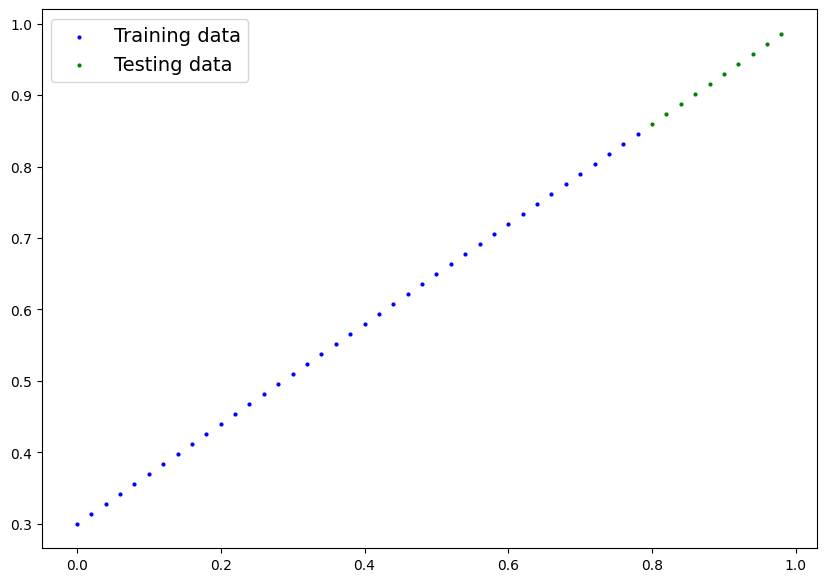

In [77]:
plot_predictions();

# **2. Build model**

In [78]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

Checking the contents of a PyTorch **model**

In [79]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [80]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Making predictions using torch.inference_mode()**bold text**

In [81]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [82]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


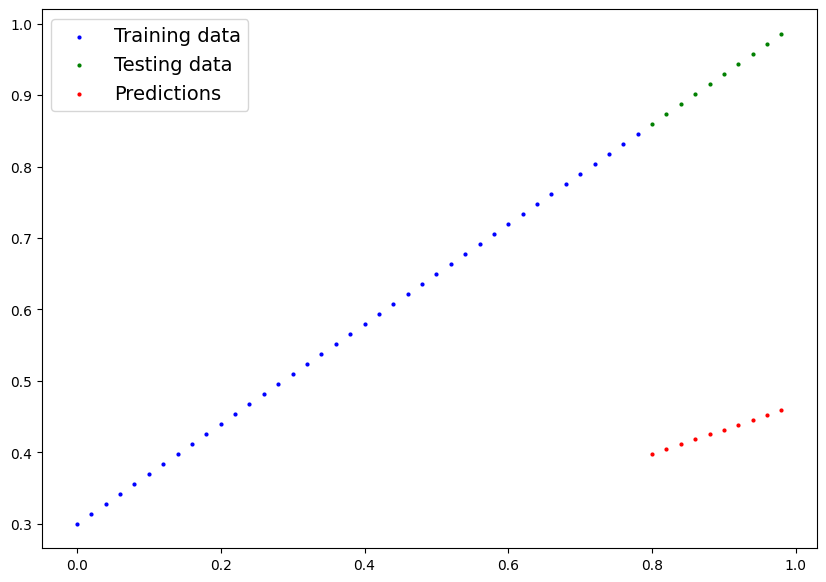

In [83]:
plot_predictions(predictions=y_preds)

In [84]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

# **3. Train model**

Creating a loss function and optimizer in PyTorch

In [85]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [86]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


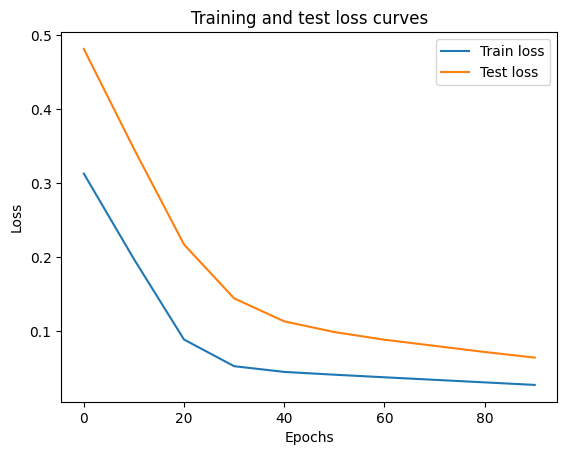

In [87]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [88]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# **4. Making predictions with a trained PyTorch model (inference)**

In [89]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

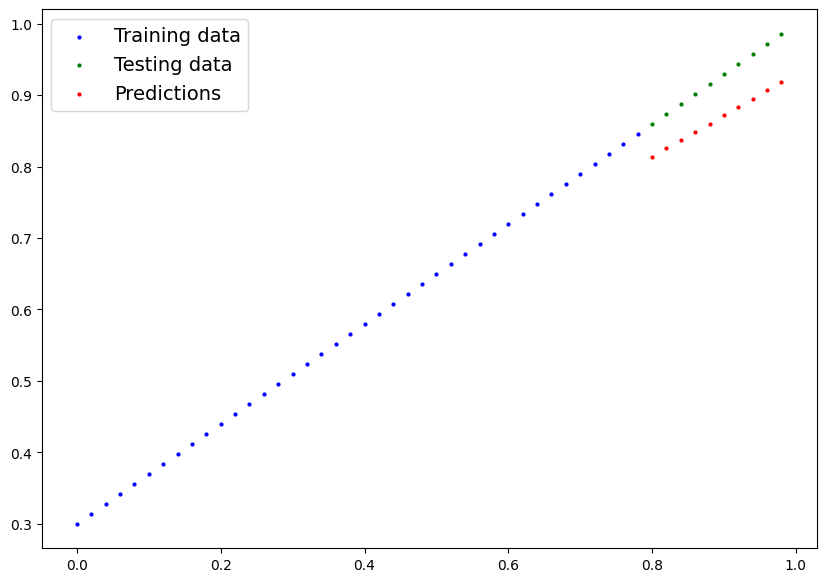

In [90]:
plot_predictions(predictions=y_preds)

# **5. Saving and loading a PyTorch model**

**Saving a PyTorch model's state_dict()**

In [91]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [92]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Apr 11 23:55 models/01_pytorch_workflow_model_0.pth


**Loading a saved PyTorch model's state_dict()**

In [93]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [94]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [95]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# **6. Putting it all together**

In [96]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.2.1+cu121'

In [97]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


# **6.1 Data**

In [98]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [99]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

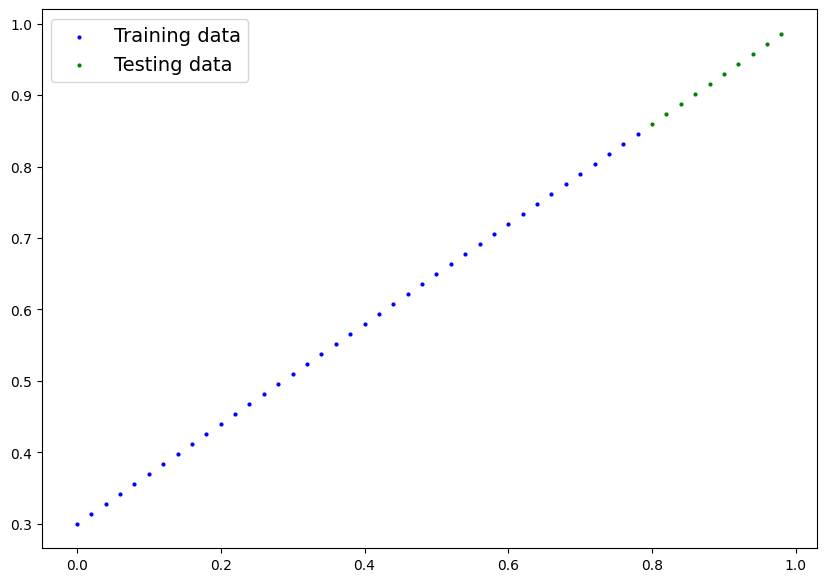

In [100]:
# Note: If you've reset your runtime, this function won't work,
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

# **6.2 Building a PyTorch linear model**

In [101]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [102]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [103]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cpu')

# **6.3 Training**

In [104]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [105]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904


In [106]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# **6.4 Making predictions**

In [107]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

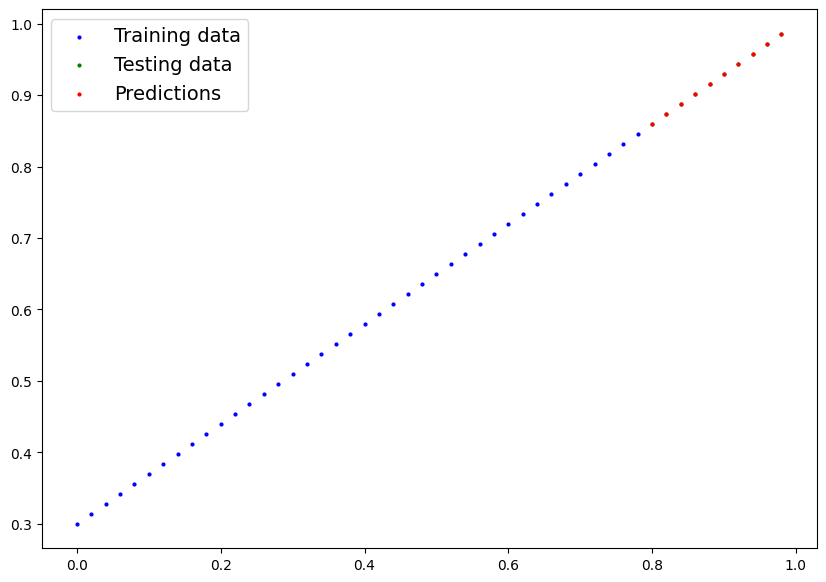

In [108]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

# **6.5 Saving and loading a model**

In [109]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [110]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


In [111]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# **Excercise**

You should be able to complete them by referencing their specific section.

Note: For all exercises, your code should be device agnostic (meaning it could run on CPU or GPU if it's available).


1.
Create a straight line dataset using the linear regression formula (weight * X + bias).
Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
Split the data into 80% training, 20% testing.
Plot the training and testing data so it becomes visual.

In [129]:
#imports
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

In [130]:
#device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using device {device}")

using device cpu


In [131]:
#creating dataset
weight = 0.3
bias = 0.9

start = 0
end = 1.5
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1)
Y = weight * X + bias
X[:10], Y[:10], X.size(), Y.size(), len(X), len(Y)

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.9000],
         [0.9030],
         [0.9060],
         [0.9090],
         [0.9120],
         [0.9150],
         [0.9180],
         [0.9210],
         [0.9240],
         [0.9270]]),
 torch.Size([150, 1]),
 torch.Size([150, 1]),
 150,
 150)

In [132]:
#Splitting
train_end = int(0.8 * len(X))
X_train, Y_train = X[:train_end], Y[:train_end]
X_test, Y_test = X[train_end: ], Y[train_end: ]

len(X_train), len(Y_train), len(X_test), len(Y_test)

(120, 120, 30, 30)

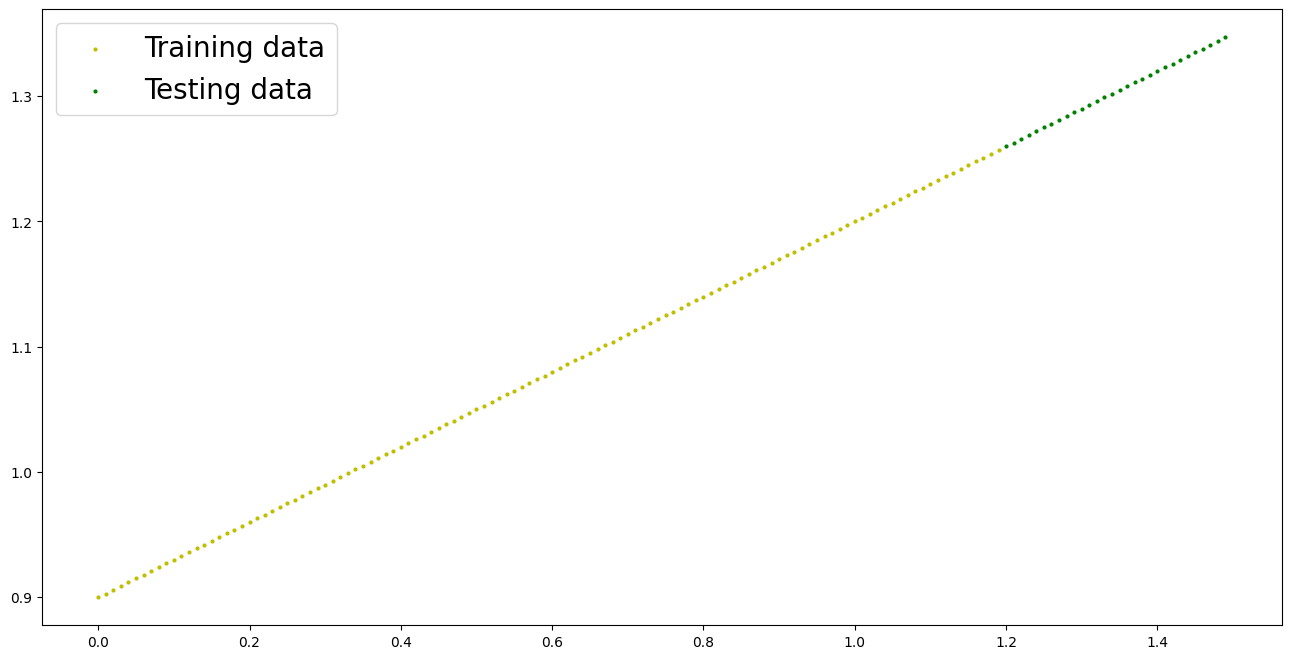

In [133]:
#Plot
#Plot Function
def plot_predictions(train_data=X_train,
                     train_labels=Y_train,
                     test_data=X_test,
                     test_labels=Y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(16,8))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="y", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 20});

plot_predictions(X_train, Y_train, X_test, Y_test)

2. Build a PyTorch model by subclassing nn.Module.
Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
Once you've constructed the model, make an instance of it and check its state_dict().
Note: If you'd like to use nn.Linear() instead of nn.Parameter() you can.

In [134]:
class LinRegModel(nn.Module):
  def __init__(self) :
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,dtype=torch.float), requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1,dtype=torch.float), requires_grad=True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

class LinRegModel2(nn.Module):
  def __init__(self) :
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

model_ex = LinRegModel()
model_ex, model_ex.state_dict()

(LinRegModel(),
 OrderedDict([('weights', tensor([-2.4661])), ('bias', tensor([0.3623]))]))

3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
Write a training loop to perform the appropriate training steps for 300 epochs.
The training loop should test the model on the test dataset every 20 epochs.

In [135]:
# Check model device
next(model_ex.parameters()).device

device(type='cpu')

In [136]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_ex.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_ex.parameters()).device

device(type='cpu')

In [137]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_ex.parameters(), lr = 0.01)

In [144]:
epochs = 300

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

for epoch in range(epochs):
    # Training
    model_ex.train()

    Y_pred = model_ex(X_train)

    loss = loss_fn(Y_pred, Y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Evaluation
    model_ex.eval()

    with torch.inference_mode():
      test_pred = model_ex(X_test)
      test_loss = loss_fn(test_pred, Y_test)

    if epoch % 20 == 0:
        print(f"{epoch} Epoch | {loss} Train Loss | {test_loss} Test Loss")


# for epoch in range(epochs):
#     ### Training
#     model_ex.train() # train mode is on by default after construction

#     # 1. Forward pass
#     Y_pred = model_ex(X_train)

#     # 2. Calculate loss
#     loss = loss_fn(Y_pred, Y_train)

#     # 3. Zero grad optimizer
#     optimizer.zero_grad()

#     # 4. Loss backward
#     loss.backward()

#     # 5. Step the optimizer
#     optimizer.step()

#     ### Testing
#     model_ex.eval() # put the model in evaluation mode for testing (inference)
#     # 1. Forward pass
#     with torch.inference_mode():
#         test_pred = model_ex(X_test)

#         # 2. Calculate the loss
#         test_loss = loss_fn(test_pred, Y_test)

#     if epoch % 20 == 0 :
#         print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")


0 Epoch | 0.02231973223388195 Train Loss | 0.04724323749542236 Test Loss
20 Epoch | 0.009514208883047104 Train Loss | 0.019176514819264412 Test Loss
40 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
60 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
80 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
100 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
120 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
140 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
160 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
180 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
200 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
220 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
240 Epoch | 0.0016032963758334517 Train Loss | 0.0172458253800869 Test Loss
260 Epoch | 0.0016

4. Make predictions with the trained model on the test data.
Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

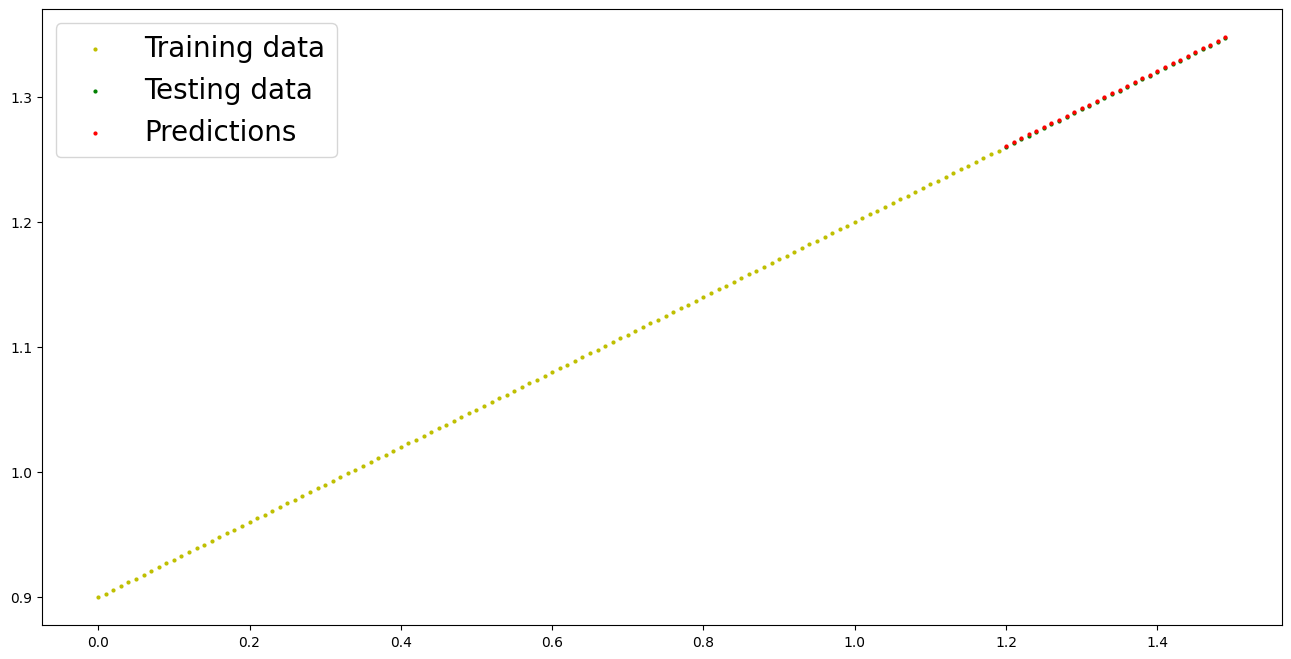

In [145]:
model_ex.eval()
with torch.inference_mode():
    Y_pred = model_ex(X_test)
    # Y_pred = Y_pred.to(device)
plot_predictions(X_train, Y_train, X_test, Y_test, Y_pred)

5. Save your trained model's state_dict() to file.

Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.

Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [146]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_excercise_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_ex.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_excercise_model.pth


In [147]:
new_ex_model = LinRegModel()
new_ex_model, new_ex_model.state_dict()

(LinRegModel(),
 OrderedDict([('weights', tensor([0.3765])), ('bias', tensor([-0.1808]))]))

In [148]:
# Load model state dict
new_ex_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
new_ex_model.to(device)

print(f"Loaded model:\n{new_ex_model}")
print(f"Model on device:\n{next(new_ex_model.parameters()).device}")

Loaded model:
LinRegModel()
Model on device:
cpu


In [150]:
# Evaluate loaded model
new_ex_model.eval()
with torch.inference_mode():
    new_ex_model_preds = new_ex_model(X_test)
Y_pred == new_ex_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])